In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import os

# Directorio que contiene los archivos pkl
directorio = '../data/'  # Actualiza con la ruta correcta

# Lista para almacenar los DataFrames de los archivos pkl
dataframes = []

# Recorre los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data = pickle.load(f)
        dataframes.append(data)

# Combina los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)

In [29]:
print(data.head())
print("filas-data-sucia: ", len(data))

   TRANSACTION_ID TIEMPO_DESDE_ULTIMA_TX_S DIA_TX CLIENTE_ID TERMINAL_ID  \
0            2585                  1732615     20        199          95   
1            2586                  1732844     20        120         162   
2            2587                  1735327     20          7         693   
3            2588                  1739460     20        197         558   
4            2589                  1740477     20          7         693   

   MONTO_TX         TX_DATETIME    year  month   day  hour  minute  \
0  48869.99 2023-01-21 01:16:55  2023.0    1.0  21.0   1.0    16.0   
1   4962.75 2023-01-21 01:20:44  2023.0    1.0  21.0   1.0    20.0   
2  27212.07 2023-01-21 02:02:07  2023.0    1.0  21.0   2.0     2.0   
3  74193.25 2023-01-21 03:11:00  2023.0    1.0  21.0   3.0    11.0   
4  30351.08 2023-01-21 03:27:57  2023.0    1.0  21.0   3.0    27.0   

   x_pos_terminal  y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
0       43.963588       23.922517         0              

In [30]:
data = data[data['TX_FRAUD'] == 1]
print(data.head())
print("total-filas: ",len(data) )

    TRANSACTION_ID TIEMPO_DESDE_ULTIMA_TX_S DIA_TX CLIENTE_ID TERMINAL_ID  \
6             2591                  1741949     20        129         658   
9             2594                  1744174     20         67         688   
15            2600                  1748566     20         54         908   
17            2602                  1749146     20         12         871   
18            2603                  1749905     20         51          22   

     MONTO_TX         TX_DATETIME    year  month   day  hour  minute  \
6    97095.99 2023-01-21 03:52:29  2023.0    1.0  21.0   3.0    52.0   
9   131620.65 2023-01-21 04:29:34  2023.0    1.0  21.0   4.0    29.0   
15   57134.67 2023-01-21 05:42:46  2023.0    1.0  21.0   5.0    42.0   
17   36025.38 2023-01-21 05:52:26  2023.0    1.0  21.0   5.0    52.0   
18   70883.08 2023-01-21 06:05:05  2023.0    1.0  21.0   6.0     5.0   

    x_pos_terminal  y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
6        18.942345       32.045263    

/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best n_estimators: 500


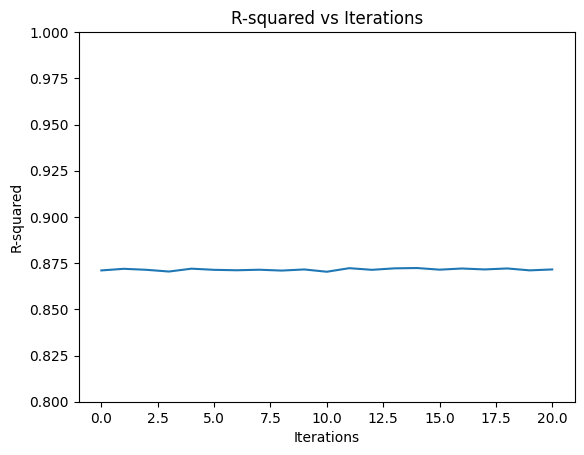

In [38]:
from sklearn.ensemble import RandomForestRegressor
from numpy import inf
from sklearn.metrics import r2_score
# Variables de entrada
X = data[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y = data[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators_range = [10, 50, 100, 200, 500]
best_r2_score = -inf
best_n_estimators = None

# Probar diferentes valores de n_estimators
for n_estimators in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n_estimators, oob_score=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # Comparar el rendimiento actual con el mejor rendimiento hasta ahora
    if r2 > best_r2_score:
        best_r2_score = r2
        best_n_estimators = n_estimators

print("Best n_estimators:", best_n_estimators)

# Crear y entrenar el modelo de regresión
n_iterations = 20
model = RandomForestRegressor(oob_score=True, min_samples_split=5, n_estimators=best_n_estimators)
model.fit(X_train, y_train)

# Obtener el R-squared inicial
initial_r2 = model.oob_score_

# Lista para almacenar los R-squared en cada etapa del entrenamiento
r2_scores = [initial_r2]

# Entrenamiento iterativo del modelo
for i in range(n_iterations):
    model.estimators_ = model.estimators_[:best_n_estimators]  # Restringir el número de estimadores para la iteración actual
    model.fit(X_train, y_train)
    r2_score = model.oob_score_
    r2_scores.append(r2_score)

# Crear el gráfico de progreso del R-squared
plt.plot(range(n_iterations + 1), r2_scores)
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('R-squared vs Iterations')
plt.ylim([0.8, 1])
plt.show()

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [32]:
y_pred_rounded = y_pred.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded[:, -4:] = y_pred_rounded[:, -4:].round().astype(int)

print(y_pred_rounded)

[[20.73839128  6.84463115  1.         16.          9.         22.        ]
 [45.22812567 45.18204154  1.         22.         13.         41.        ]
 [35.445333   36.70155018  1.          9.         11.         22.        ]
 ...
 [44.12915127 47.2076922   1.         11.         14.         52.        ]
 [35.40050514 10.55715805  1.         26.         12.         51.        ]
 [20.88832325  9.48600985  1.          9.         10.         36.        ]]


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)


Mean Squared Error (MSE): 8.010241092609826
Mean Absolute Error (MAE): 1.9958170020999122
R-squared: 0.8727907971241521


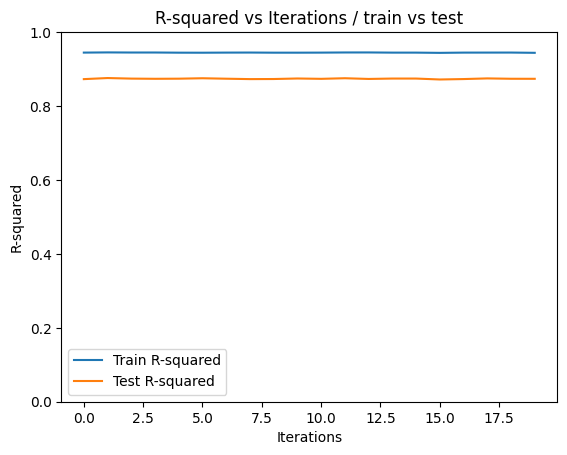

In [34]:
import matplotlib.pyplot as plt

# Crear listas para almacenar los valores de R-squared
train_r2_scores = []
test_r2_scores = []

# Entrenar el modelo y calcular el R-squared en cada iteración
for i in range(n_iterations):
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Crear el gráfico de progreso del R-squared
plt.plot(range(n_iterations), train_r2_scores, label='Train R-squared')
plt.plot(range(n_iterations), test_r2_scores, label='Test R-squared')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('R-squared vs Iterations / train vs test')
plt.ylim([0, 1])
plt.legend()
plt.show()

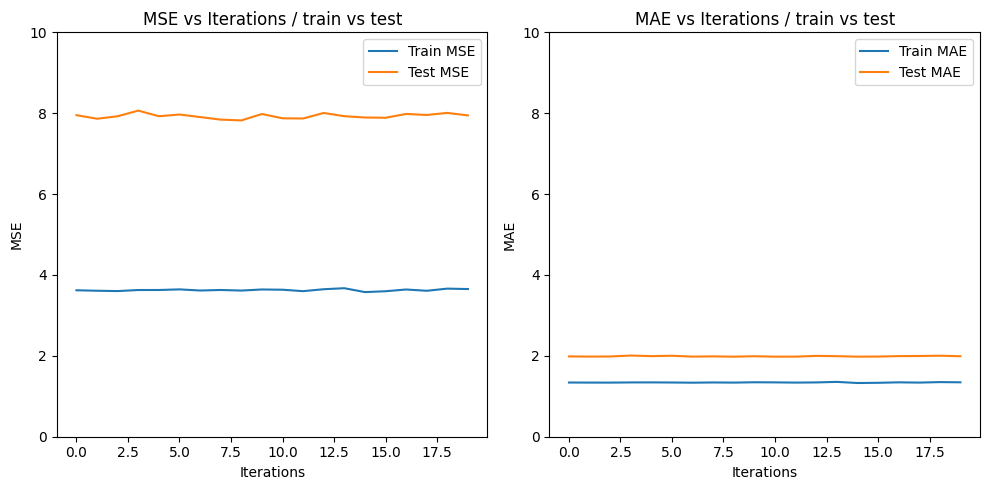

In [35]:
# Crear listas para almacenar los valores del MSE y el MAE
train_mse_scores = []
test_mse_scores = []
train_mae_scores = []
test_mae_scores = []

# Entrenar el modelo y calcular el MSE y el MAE en cada iteración
for i in range(n_iterations):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)

# Crear los gráficos de progreso del MSE y el MAE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(n_iterations), train_mse_scores, label='Train MSE')
plt.plot(range(n_iterations), test_mse_scores, label='Test MSE')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE vs Iterations / train vs test')
plt.ylim([0, 10])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(n_iterations), train_mae_scores, label='Train MAE')
plt.plot(range(n_iterations), test_mae_scores, label='Test MAE')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('MAE vs Iterations / train vs test')
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.show()

/home/codespace/.python/current/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/codespace/.python/current/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/codespace/.python/current/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/c

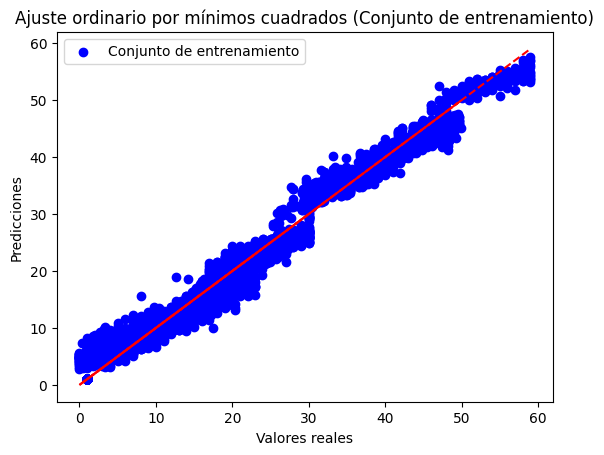

/home/codespace/.python/current/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/codespace/.python/current/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/codespace/.python/current/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/c

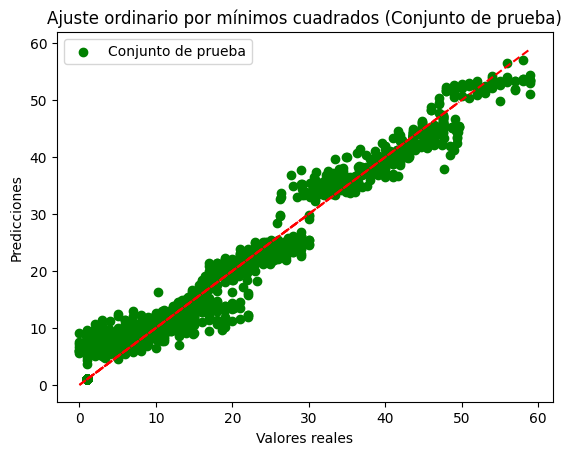

Coeficiente de determinación (R^2) - Conjunto de entrenamiento: 0.94
Coeficiente de determinación (R^2) - Conjunto de prueba: 0.87


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Obtener las predicciones del modelo para el conjunto de entrenamiento
y_train_pred = model.predict(X_train)

# Obtener las predicciones del modelo para el conjunto de prueba
y_test_pred = model.predict(X_test)

# Calcular el coeficiente de determinación para el conjunto de entrenamiento
r2_train = r2_score(y_train, y_train_pred)

# Calcular el coeficiente de determinación para el conjunto de prueba
r2_test = r2_score(y_test, y_test_pred)

# Graficar las predicciones vs. los valores reales para el conjunto de entrenamiento
plt.scatter(y_train, y_train_pred, color='blue', label='Conjunto de entrenamiento')
plt.plot([np.min(y_train), np.max(y_train)], [np.min(y_train), np.max(y_train)], color='red', linestyle='--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Ajuste ordinario por mínimos cuadrados (Conjunto de entrenamiento)')
plt.legend()
plt.show()

# Graficar las predicciones vs. los valores reales para el conjunto de prueba
plt.scatter(y_test, y_test_pred, color='green', label='Conjunto de prueba')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Ajuste ordinario por mínimos cuadrados (Conjunto de prueba)')
plt.legend()
plt.show()

# Imprimir los coeficientes de determinación
print("Coeficiente de determinación (R^2) - Conjunto de entrenamiento: {:.2f}".format(r2_train))
print("Coeficiente de determinación (R^2) - Conjunto de prueba: {:.2f}".format(r2_test))